# test_cylinder.ipynb

### Install

In [ ]:
pip install git+https://github.com/grmacchio/dynml.git

### Imports and Data Type Settings

In [19]:
from matplotlib.pyplot import subplots, show
from random import seed
from time import time
from tqdm import trange

from numpy import polyfit
from scipy.signal import find_peaks
from torch import arange, cat, float64, linspace, log, mean, set_default_dtype
from torch import stack, tensor, Tensor, where
from torch.cuda.random import manual_seed as cuda_manual_seed
from torch.nn.functional import interpolate as torch_interp
from torch.random import manual_seed as torch_manual_seed

from dynml.examples.cylinder import Cylinder
from dynml.dyn.discrete.numsolve import gen_num_trajs

In [20]:
seed(0)
torch_manual_seed(0)
cuda_manual_seed(0)

In [21]:
set_default_dtype(float64)

### Generate a Trajectory

In [ ]:
ds = Cylinder()
t_chunk = 50.0
num_chunks = 12
num_samples = int(t_chunk / ds.dt) + 1
traj = gen_num_trajs(ds, ds.gen_rand_ic, 1, num_samples)
for _ in range(num_chunks - 1):
    traj = gen_num_trajs(ds, lambda: traj[0, -1], 1, num_samples)

100%|██████████| 3767/3767 [13:49<00:00,  4.54it/s]


### Examine The Last State

In [12]:
psi = traj[..., 0]
omega = traj[..., 1]

omega_last = omega[0, -1, :, :]
psi_last = psi[0, -1, :, :]
u1_last, u2_last = ds._vel(psi[0, -1, :, :])

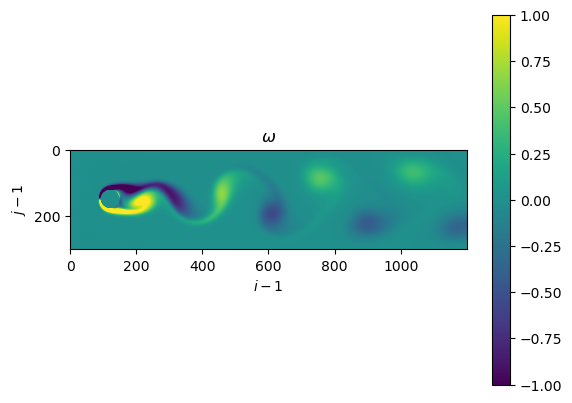

In [14]:
fig, ax = subplots()
plot = ax.imshow(omega_last, vmin=-1.0, vmax=1.0)
fig.colorbar(plot)
ax.set_title("$\\omega$")
ax.set_xlabel("$i - 1$")
ax.set_ylabel("$j - 1$")
show()

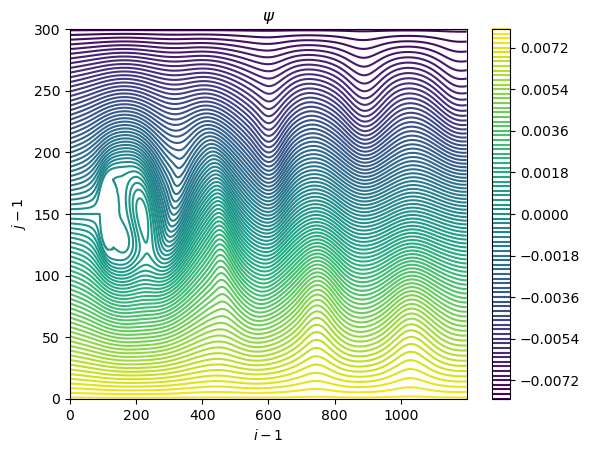

In [21]:
fig, ax = subplots()
plot = ax.contour(psi_last, levels=100)
fig.colorbar(plot)
ax.set_title("$\\psi$")
ax.set_xlabel("$i - 1$")
ax.set_ylabel("$j - 1$")
show()

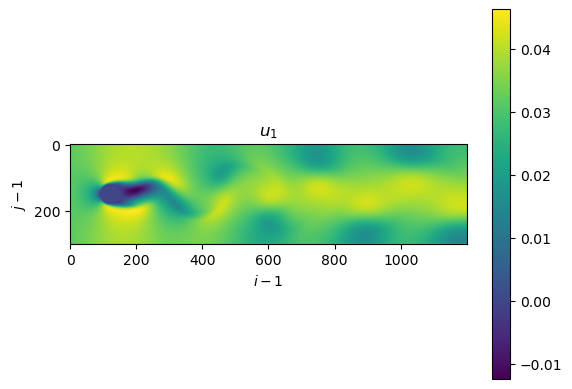

In [16]:
fig, ax = subplots()
plot = ax.imshow(u1_last)
fig.colorbar(plot)
ax.set_title("$u_1$")
ax.set_xlabel("$i - 1$")
ax.set_ylabel("$j - 1$")
show()

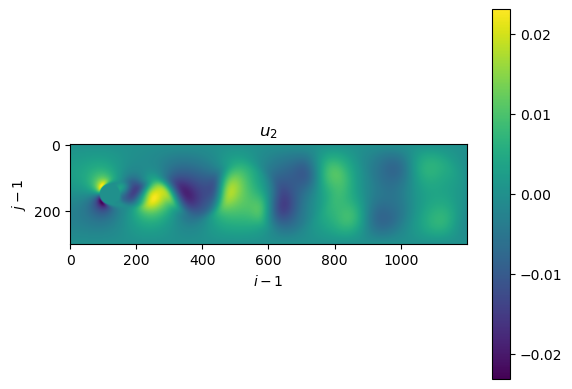

In [17]:
fig, ax = subplots()
plot = ax.imshow(u2_last)
fig.colorbar(plot)
ax.set_title("$u_2$")
ax.set_xlabel("$i - 1$")
ax.set_ylabel("$j - 1$")
show()

### Examine the Strouhal Number

Strouhal number: 0.204


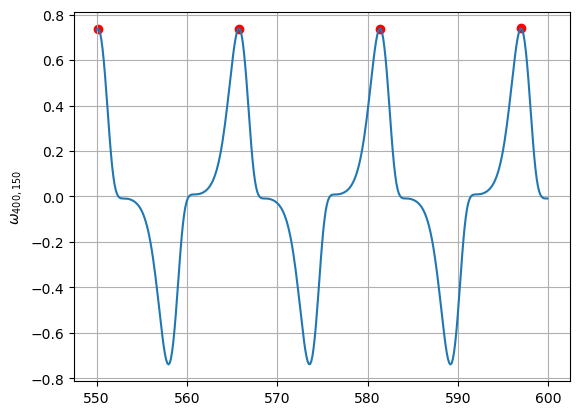

In [ ]:
fig, ax = subplots()
t1 = (num_chunks - 1) * t_chunk
t2 = num_chunks * t_chunk
t_span = linspace(t1, t2, num_samples)[::10]
w = omega[0, ::10, ds.N_2, 400]
peaks, _ = find_peaks(w, height=0.1)
T = mean(t_span[peaks[1:]] - t_span[peaks[:-1]])
f = 1 / T
Sr = f * (2 * ds.R) / ds.U_inf
print(f"Strouhal number: {Sr:.3f}")
ax.plot(t_span, w)
ax.grid()
ax.scatter(t_span[peaks], w[peaks], marker='o', color='red')
ax.set_ylabel('$\\omega_{400, 150}$')
ax.set_xlabel('$t$')
show()

### Examine The Stability of the Simulation with Respect to the Time Step

In [4]:
ds = Cylinder(L_1=1.0, L_2=0.25, N_1=600, N_2=150)
dt_cfl = min(ds.ds1, ds.ds2) / (2 * ds.U_inf)
t_final = 600.0
ic = ds.gen_inviscid_ic()
dt_list = [dt_cfl * 4, dt_cfl * 2, dt_cfl * 1, dt_cfl * 0.5, dt_cfl * 0.25]
norm_list = []
for n, dt in enumerate(dt_list):
    num_samples = int(t_final / dt) + 1
    ds = Cylinder(L_1=1.0, L_2=0.25, N_1=600, N_2=150)
    ds.dt = dt
    x = ic
    norm_list.append([])
    norm_list[n].append(x.flatten().norm().item())
    for k in trange(num_samples - 1):
        try:
            x = ds.map(x)
            norm_list[n].append(x.flatten().norm().item())
        except Exception as e:
            print(f"{e}")
            break

100%|██████████| 90431/90431 [38:11<00:00, 39.47it/s] 


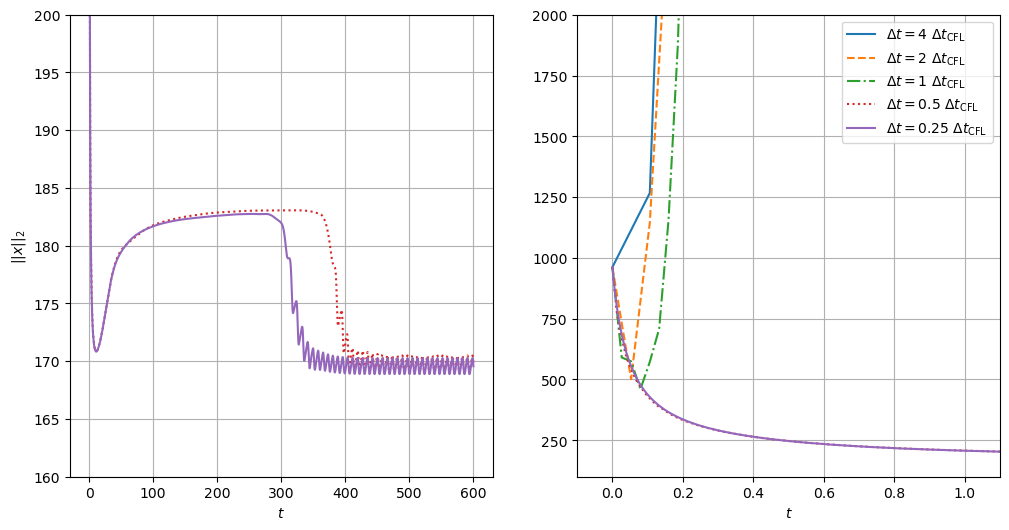

In [23]:
fig, ax = subplots(1, 2, figsize=(12, 6))
mults = [4, 2, 1, 0.5, 0.25]
styles = ['-', '--', '-.', ':', '-']
for n, dt in enumerate(dt_list):
    t_span = linspace(0, t_final, len(norm_list[n]))
    label = f'$\\Delta t = {mults[n]}$' + ' $\\Delta t_{\\text{CFL}}$'
    ax[0].plot(t_span, norm_list[n], label=label, linestyle=styles[n])
    ax[1].plot(t_span, norm_list[n], label=label, linestyle=styles[n])
ax[0].set_ylim(160, 2e2)
ax[1].set_xlim(-0.1, 1.1)
ax[1].set_ylim(1e2, 2e3)
ax[0].set_ylabel("$||x||_2$")
ax[0].set_xlabel("$t$")
ax[1].set_xlabel("$t$")
ax[1].legend()
ax[0].grid()
ax[1].grid()
show()

### Examine The Accuracy of Solutions with Respect to Resolution

In [4]:
ds_s1 = Cylinder(L_1=1.0, L_2=0.5, N_1=128, N_2=64)
ds_s2 = Cylinder(L_1=1.0, L_2=0.5, N_1=256, N_2=128)
ds_s3 = Cylinder(L_1=1.0, L_2=0.5, N_1=512, N_2=256)
ds_ref = Cylinder(L_1=1.0, L_2=0.5, N_1=1024, N_2=512)

x1 = ds_s1.gen_inviscid_ic()
x2 = ds_s2.gen_inviscid_ic()
x3 = ds_s3.gen_inviscid_ic()
x_ref = ds_ref.gen_inviscid_ic()

ds_s1.dt = 0.1 * ds_ref.dt
ds_s2.dt = 0.1 * ds_ref.dt
ds_s3.dt = 0.1 * ds_ref.dt
ds_ref.dt = 0.1 * ds_ref.dt

Grid spacing should be smaller than 10 * self.nu / self.U_inf = 0.0050. Currently, self.ds2 = 0.0078 and self.ds1 = 0.0079.


In [5]:
def interpolate(x: Tensor, ds: Cylinder) -> Tensor:
    psi = x[:, :, 0]
    psi_top = psi[0:ds.N_2 + 1].unsqueeze(0).unsqueeze(0)
    psi_bot = psi[ds.N_2:, :].unsqueeze(0).unsqueeze(0)
    psi_top_interp = torch_interp(psi_top, size=(ds_ref.N_2 + 1, ds_ref.N_1), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)
    psi_bot_interp = torch_interp(psi_bot, size=(ds_ref.N_2 + 1, ds_ref.N_1), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)
    psi = cat((psi_top_interp, psi_bot_interp[1:, :]), dim=0)
    psi = where(ds_ref.mask == 0, psi, 0)
    omega = x[:, :, 1]
    omega_top = omega[0:ds.N_2 + 1].unsqueeze(0).unsqueeze(0)
    omega_bot = omega[ds.N_2:, :].unsqueeze(0).unsqueeze(0)
    omega_top_interp = torch_interp(omega_top, size=(ds_ref.N_2 + 1, ds_ref.N_1), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)
    omega_bot_interp = torch_interp(omega_bot, size=(ds_ref.N_2 + 1, ds_ref.N_1), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)
    omega = cat((omega_top_interp, omega_bot_interp[1:, :]), dim=0)
    omega = where(ds_ref.mask == 1, 0, omega)
    return stack((psi, omega), dim=-1)

In [6]:
error1 = [(interpolate(x1, ds_s1) - x_ref).flatten().norm().item()]
error2 = [(interpolate(x2, ds_s2) - x_ref).flatten().norm().item()]
error3 = [(interpolate(x3, ds_s3) - x_ref).flatten().norm().item()]
time1 = [0.0]
time2 = [0.0]
time3 = [0.0]
timeref = [0.0]
t_final = 100.0
num_samples = int(t_final / ds_ref.dt) + 1
for k in trange(num_samples - 1):
    t0 = time()
    x1 = ds_s1.map(x1)
    time1.append(time() - t0)
    t0 = time()
    x2 = ds_s2.map(x2)
    time2.append(time() - t0)
    t0 = time()
    x3 = ds_s3.map(x3)
    time3.append(time() - t0)
    t0 = time()
    x_ref = ds_ref.map(x_ref)
    timeref.append(time() - t0)
    error1.append((interpolate(x1, ds_s1) - x_ref).flatten().norm().item())
    error2.append((interpolate(x2, ds_s2) - x_ref).flatten().norm().item())
    error3.append((interpolate(x3, ds_s3) - x_ref).flatten().norm().item())

100%|██████████| 128614/128614 [3:07:17<00:00, 11.44it/s] 


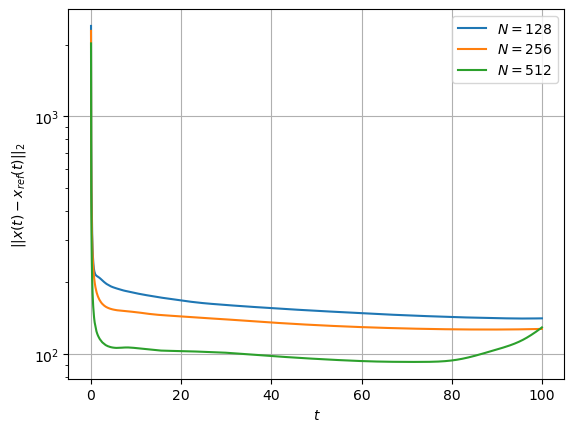

In [26]:
fig, ax = subplots(1, 1)
ax.semilogy(linspace(0, t_final, num_samples), error1, label='$N = 128$')
ax.semilogy(linspace(0, t_final, num_samples), error2, label='$N = 256$')
ax.semilogy(linspace(0, t_final, num_samples), error3, label='$N = 512$')
ax.grid()
ax.legend()
ax.set_xlabel('$t$')
ax.set_ylabel('$||x(t) - x_{ref}(t)||_2$')
show()

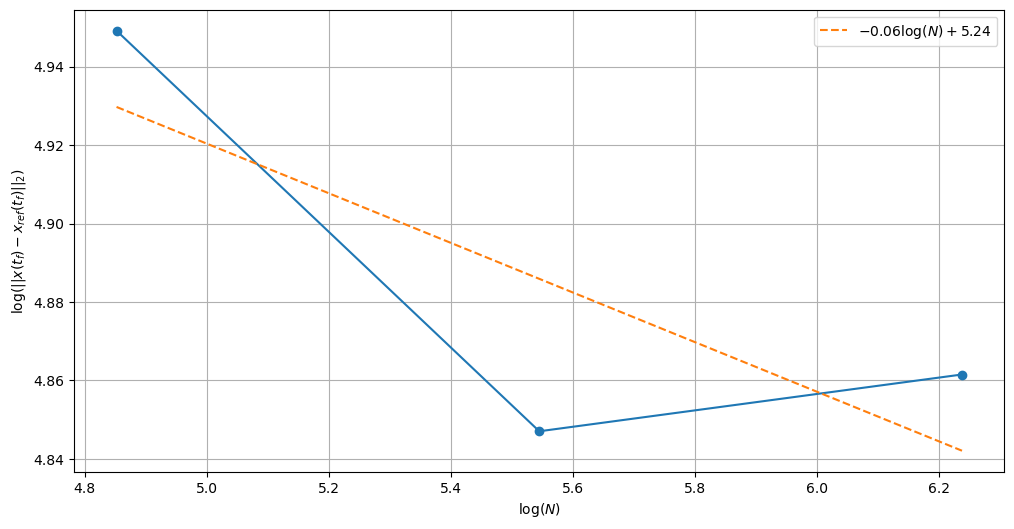

In [23]:
fig, ax = subplots(1, 1, figsize=(12, 6))
N_list = tensor([128, 256, 512])
error_list = tensor([error1[-1], error2[-1], error3[-1]])
ax.plot(log(N_list), log(error_list), marker='o')
ax.set_xlabel('$\\log(N)$')
ax.set_ylabel('$\\log(||x(t_f) - x_{ref}(t_f)||_2)$')
ax.grid()
p = polyfit(log(N_list), log(error_list), 1)
ax.plot(log(N_list), log(N_list) * p[0] + p[1], linestyle='--', label=f'${p[0]:.2f} \\log(N) + {p[1]:.2f}$')
ax.legend()
show()

### Examine the Time Complexity as a Function Resolution

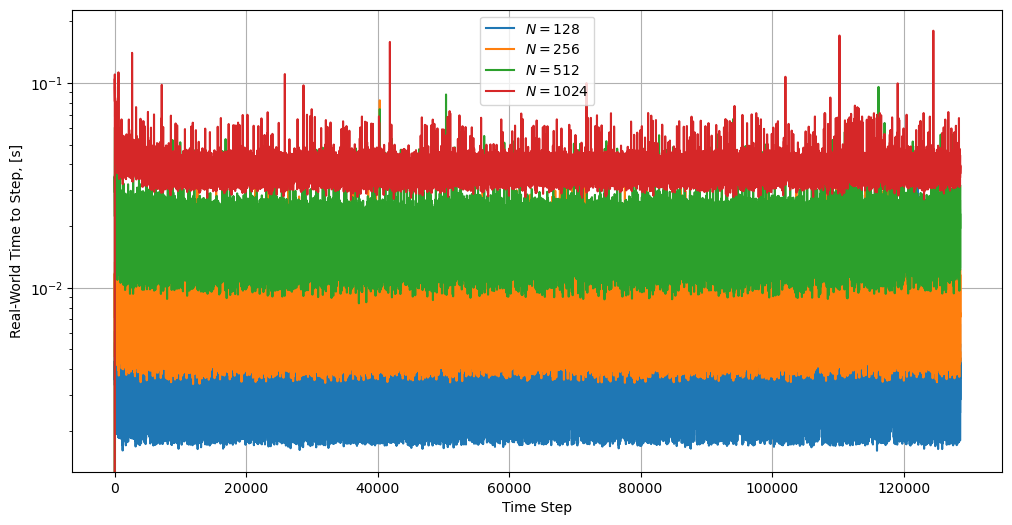

In [24]:
fig, ax = subplots(1, 1, figsize=(12, 6))
ax.semilogy(arange(0, num_samples), time1, label='$N = 128$')
ax.semilogy(arange(0, num_samples), time2, label='$N = 256$')
ax.semilogy(arange(0, num_samples), time3, label='$N = 512$')
ax.semilogy(arange(0, num_samples), timeref, label='$N = 1024$')
ax.grid()
ax.legend()
ax.set_xlabel('Time Step')
ax.set_ylabel('Real-World Time to Step, [s]')
show()

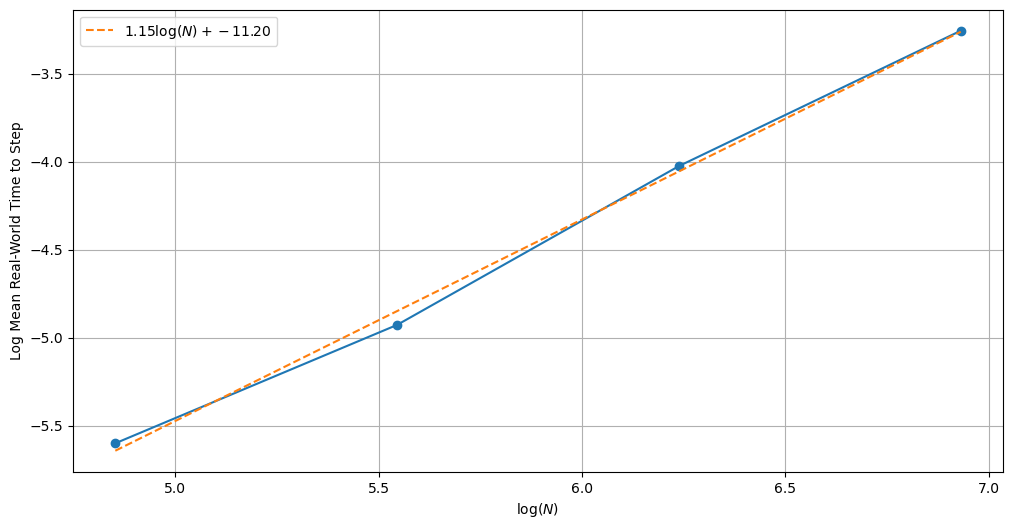

In [28]:
fig, ax = subplots(1, 1, figsize=(12, 6))
N_list = tensor([128, 256, 512, 1024])
time_list = tensor([mean(tensor(time1)),
                    mean(tensor(time2)),
                    mean(tensor(time3)),
                    mean(tensor(timeref))])
ax.plot(log(N_list), log(time_list), marker='o')
ax.set_xlabel('$\\log(N)$')
ax.set_ylabel('Log Mean Real-World Time to Step')
ax.grid()
p = polyfit(log(N_list), log(time_list), 1)
ax.plot(log(N_list), log(N_list) * p[0] + p[1], linestyle='--', label=f'${p[0]:.2f} \\log(N) + {p[1]:.2f}$')
ax.legend()
show()